# MOM-SIS 0.1$^\circ$ Diagnostics

This notebook calculates and retains key diagnostics from our mom01v5 simulations. The following experiments are included:

| Experiment Name | Description |
|-----------------|-----------------|
|GFDL50 | Original simulation with 50 vertical levels. Ran from Levitus for about 60 years, but data output only saved from about year 40.|
|KDS75 | Branched from GFDL50 at year 45 (re-zeroed), but with Kial Stewart's 75 level scheme. Has now run for 103 years. Years 90-100 have 5-daily output.|
| KDS75_wind | Short (5-year) Antarctic wind perturbation case, branched from KDS75 at year 40.|
| KDS75_PI | Paul Spence's Poleward Intensification wind experiment. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade|
| KDS75_UP | Paul Spence's Increased winds case. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade. (In Progress) |

**Last updated March 30 2017.**

https://github.com/OceansAus/cosima-cookbook.git

In [1]:
DataDir = '/g/data3/hh5/tmp/cosima/mom01v5'

### Experiments

In [2]:
expts = ['GFDL50','KDS75','KDS75_UP','KDS75_PI','KDS75_wind']

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync
from dask.diagnostics import ProgressBar

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

#import datashader

In [4]:
pbar = ProgressBar()
pbar.register()

In [5]:
# set up dask to initiate 4 parallel processors.
dask.set_options(get=dask.multiprocessing.get, num_workers=4)

## Wind Stress fields
The following code block shows the zonal- and time-averaged wind stress forcing for each experiment.

GFDL50 - Already Processed
KDS75 - Already Processed
KDS75_UP - Already Processed
KDS75_PI - Already Processed
KDS75_wind - Already Processed


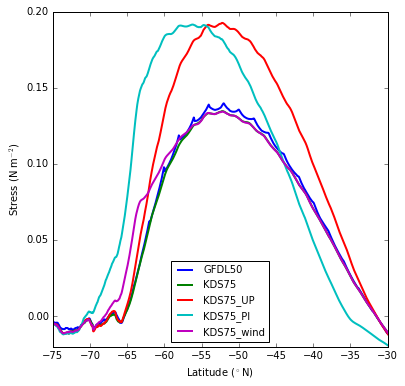

In [6]:
plt.figure(figsize=(6,6))
for e in expts:
    ExpDir = os.path.join(DataDir,e)

    # Is there any processed data to load?
    AvgeWindFile = os.path.join(ExpDir,'TauX_Last5Years.nc')
    if os.path.exists(AvgeWindFile):
        print (e + ' - Already Processed')
    else: 
        # average last 20 outputs (~ 5 years)
        FileList = [f for f in os.listdir(ExpDir) if f.startswith('output')]
        FileList.sort()
        FileString = ''
        for f in FileList[-20:]:
            FileString  = FileString + ' ' + ExpDir + '/' + f + '/ocean_month.nc' 

        NCRA_COMMAND = "ncra " + FileString + ' -v tau_x ' + AvgeWindFile
        print (NCRA_COMMAND)
        print (" ")
        result = os.system(NCRA_COMMAND)
        if result != 0:
            print ("\nERROR code for NCRA: %s" % (result))

    nc = Dataset(AvgeWindFile)
    tau = nc.variables['tau_x'][:,:,:]
    lat = nc.variables['yu_ocean'][:]
    nc.close()

    tau_bar = np.ma.mean(tau,axis=2)[0,:]
    plt.plot(lat,tau_bar,linewidth=2,label=e)

plt.xlim([-75,-30])
plt.ylim([-0.02,0.2])
plt.xlabel('Latitude ($^\circ$N)')
plt.ylabel('Stress (N m$^{-2}$)')
plt.legend(loc=8,fontsize=10)
plt.savefig('figures/WindStress.pdf')

# Major Transports
In this section, we catalogue and save transport diagnostics from each of the major straits.

Still to think about:
* Should we put the background functions into a separate python file and load as a module?


In [7]:
StraightDicts = { 'DrakePassage' :  {'xloc':2100,'ymin':225,'ymax':650},
              'Lombok' : {'yloc':1158,'xmin':354,'xmax':361},
              'Ombai' : {'xloc':449,'ymin':1152,'ymax':1163},
              'Timor' : {'xloc':440,'ymin':1125,'ymax':1145},
              'Bering' : {'yloc':2125,'xmin':1080,'xmax':1130},
              'Denmark' : {'yloc':2125,'xmin':2380,'xmax':2580},
            }

In [8]:
## This code block contains functions which we may move to an external module someday ...

## Function to calculate barotropic transport across a given line of latitude or longitude.
## Primarily designed for flow through straits.
def calculate_transport(OceanFile, TransDict):
    try:
        dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
        if 'xloc' in TransDict:
            tx_trans = dsx.tx_trans[0,:,TransDict['ymin']:TransDict['ymax'],TransDict['xloc']]
            transport = tx_trans.sum()
            valrange = tx_trans.valid_range[1]
        elif 'yloc' in TransDict:
            ty_trans = dsx.ty_trans[0,:,TransDict['yloc'],TransDict['xmin']:TransDict['xmax']]
            transport = ty_trans.sum()
            valrange = ty_trans.valid_range[1]
        else:
            transport = np.nan

        if np.isnan(transport.values):
            transport = np.nan
        elif transport.values > valrange:
            transport = np.nan
                
    except:
        transport = np.nan
    
    return OceanFile, transport

In [9]:
for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    for straight in StraightDicts:
        # Is there any processed data to load?
        MetricsFile = '{}Transport.pkl'.format(straight)
    
        if os.path.exists(MetricsFile):
            transports = pickle.load(open(MetricsFile, 'rb'))
        
            ProcessedFiles = transports.keys()
            FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
        else:
            transports = {}
            FilesToProcess = FileList

        delayed_transports = [delayed(calculate_transport)(fn, StraightDicts[straight]) for fn in FilesToProcess]
        data = delayed(list)(delayed_transports)
    
        transports.update({x[0]: x[1] for x in data.compute(num_workers=8) if not np.isnan(x[1])})
        pickle.dump( transports, open( MetricsFile, "wb" ))

[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

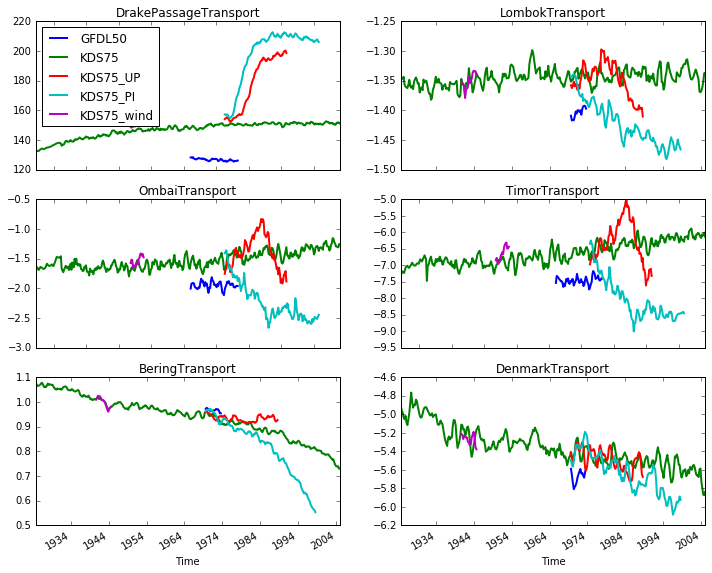

In [10]:
plt.figure(figsize=(12,10))
MetricsFiles = ['DrakePassageTransport.pkl','LombokTransport.pkl','OmbaiTransport.pkl',
                'TimorTransport.pkl', 'BeringTransport.pkl', 'DenmarkTransport.pkl']

for expt in expts:  
    nplot = 0
    for MetricsFile in MetricsFiles:
        nplot += 1
        transports = pickle.load(open(MetricsFile, 'rb'))
        # pull out transports for the given experiment
        transports = sorted([(name, value) for name, value in transports.items() if expt+'/' in name])
        transports = [v[1] for v in transports]
        
        # interpret time as days since the year 1900
        transport = xr.concat(transports, dim='time').to_dataset()
        transport["time"].attrs["units"] = 'days since 1900-01-01'
        transport = xr.decode_cf(transport, decode_times=True)
    
        plt.subplot(3,2,nplot)
        try:
            transport = transport.tx_trans
        except:
            transport = transport.ty_trans
            
        r = transport.rolling(time=4, center=True).mean()
        r.plot(label=expt, linewidth=2)
        
        plt.title(MetricsFile[:-4])

plt.subplot(321)
plt.legend(loc='upper left')
#plt.ylabel('Transport (Sv)')
plt.xlabel('')
plt.subplot(322)
#plt.ylabel('')
plt.xlabel('')
plt.subplot(323)
#plt.ylabel('Transport (Sv)')
plt.xlabel('')
plt.subplot(324)
#plt.ylabel('')
plt.xlabel('')
plt.subplot(325)
#plt.ylabel('Transport (Sv)')
plt.xlabel('Time')
plt.subplot(326)
#plt.ylabel('')
plt.xlabel('Time')

plt.savefig('figures/Transports.pdf')

# Scalar Quantities
Look at some quantities that are saved in ocean_scalar.nc.

In [11]:
def extract_data(f):
    dataset = Dataset(f)
    
    data = {}
    for v in dataset.variables.values():
        if 'time' in v.dimensions and 'scalar_axis' in v.dimensions:
            data[v.name] = v[:].flatten()
    index = pd.to_datetime(dataset['time'][:], unit='D')
    df = pd.DataFrame(index=index, data=data)
    return df

scalar_quantities = {}

for expt in expts:
    expdir = os.path.join(DataDir,expt)
    DataFileList = glob(os.path.join(expdir, 'output*/ocean_scalar.nc'))

    frames = [ delayed(extract_data)(f) for f in DataFileList]
    if len(frames) > 0:
        scalar_quantities[expt] = delayed(pd.concat)(frames).compute(num_workers=4)

[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed | 10.1s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  0.6s


In [12]:
scalar_quantities['KDS75'].describe().T

,count,mean,std,min,25%,50%,75%,max
eta_global,1145.0,-1.598189e-02,6.130465e-03,-2.519551e-02,-2.221507e-02,-1.538861e-02,-9.511603e-03,-7.689955e-03
ke_tot,1145.0,3.207195e+03,4.285521e+01,3.069407e+03,3.178266e+03,3.207998e+03,3.236250e+03,3.337936e+03
pe_tot,1145.0,2.923421e+10,2.176188e+05,2.923390e+10,2.923395e+10,2.923397e+10,2.923407e+10,2.923417e+10
rhoave,1145.0,1.037503e+03,8.539573e-03,1.037507e+03,1.037511e+03,1.037512e+03,1.037513e+03,1.037514e+03
salt_global_ave,1145.0,3.471843e+01,3.064396e-04,3.471807e+01,3.471810e+01,3.471812e+01,3.471817e+01,3.471822e+01
salt_surface_ave,1145.0,3.457363e+01,4.112007e-02,3.446720e+01,3.454621e+01,3.457931e+01,3.460471e+01,3.464874e+01
temp_global_ave,1145.0,3.586384e+00,8.202937e-03,3.571681e+00,3.580361e+00,3.585077e+00,3.591473e+00,3.610647e+00
temp_surface_ave,1145.0,1.818336e+01,1.870137e-01,1.782593e+01,1.811521e+01,1.820282e+01,1.831544e+01,1.849554e+01
total_net_sfc_heating,1145.0,6.852601e-02,4.474402e+00,-7.733866e+00,-4.983775e+00,1.707373e+00,3.883262e+00,5.808866e+00
total_ocean_calving,1145.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


CPU times: user 734 ms, sys: 1.06 s, total: 1.8 s
Wall time: 715 ms


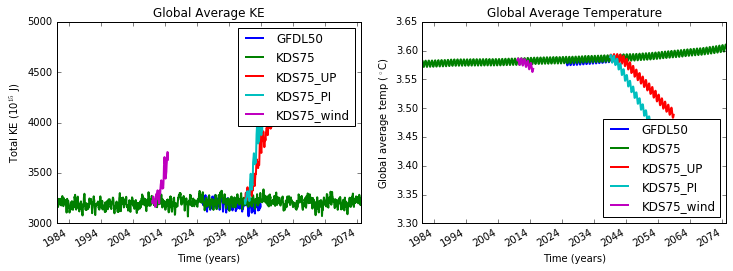

In [13]:
%%time

plt.figure(figsize=(12,4))

for expt in expts:
    plt.subplot(121)
    scalar_quantities[expt].ke_tot.plot(label=expt, linewidth=2)

    plt.subplot(122)
    scalar_quantities[expt].temp_global_ave.plot(label=expt, linewidth=2)

plt.subplot(121)
plt.legend(loc='upper right')
plt.ylabel('Total KE (10$^{15}$ J)')
plt.xlabel('Time (years)')
plt.title('Global Average KE')

plt.subplot(122)
plt.legend(loc='lower right')
plt.ylabel('Global average temp ($^\circ$C)')
plt.xlabel('Time (years)')
plt.title('Global Average Temperature')

plt.savefig('figures/Scalars.pdf')

# Overturning Circulation
Next, let's look at overturning circulation in density space using ty_trans_rho. We will zonally average this diagnostic, without accounting for the tripolar grid, so ignore the Arctic.

In [14]:
def calculate_Ψ(expt, count = 4):
    ExpDir = os.path.join(DataDir, expt)

    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()

    Ψ = 0
    for OceanFile in FileList[-count:]: 
        ## I am having trouble with chunking, so have opted for the slower non-chunking option until
        ## we can find a fix. -- AH 8/4/17.
        dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
        #dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4', chunks={'potrho':5})
        
        psi_partial = dsx.ty_trans_rho.isel(time=0).sum('grid_xt_ocean').cumsum('potrho')
        dsx.close()

        Ψ = Ψ + psi_partial

    Ψ_avg = Ψ/count

    return Ψ_avg


In [15]:
def plot_psi(psi, expt, clev=np.arange(-20,20,2)):
    #x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

    plt.contourf(psi.grid_yu_ocean, psi.potrho, psi, cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    #plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

In [16]:
%%time
## One of our problems here is that the zonal sum and density-wise cumulative sum in calculate_Ψ is so slow.
## A possible work-around is to calculate them once, save as a netCDF file, and then simply read in multiple
## netcdf files when it is time to average them, or to construct timeseries.

## Here is a first cut of doing that ... 

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*'))
    FileList.sort()
    
    for fn in FileList[:170]:
        MOCFile = os.path.join(fn, 'overturning.nc')
    
        # Have I Processed this one yet?
        if not os.path.exists(MOCFile):
            OceanFile = os.path.join(fn, 'ocean.nc')
            if os.path.exists(OceanFile):
                dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
                psi = dsx.ty_trans_rho.isel(time=0).sum('grid_xt_ocean').cumsum('potrho')
                dsx.close()
                psi.to_netcdf(MOCFile, mode='w', engine='netcdf4')
                print('Saved ', MOCFile)

CPU times: user 14 ms, sys: 22 ms, total: 36 ms
Wall time: 448 ms


[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100

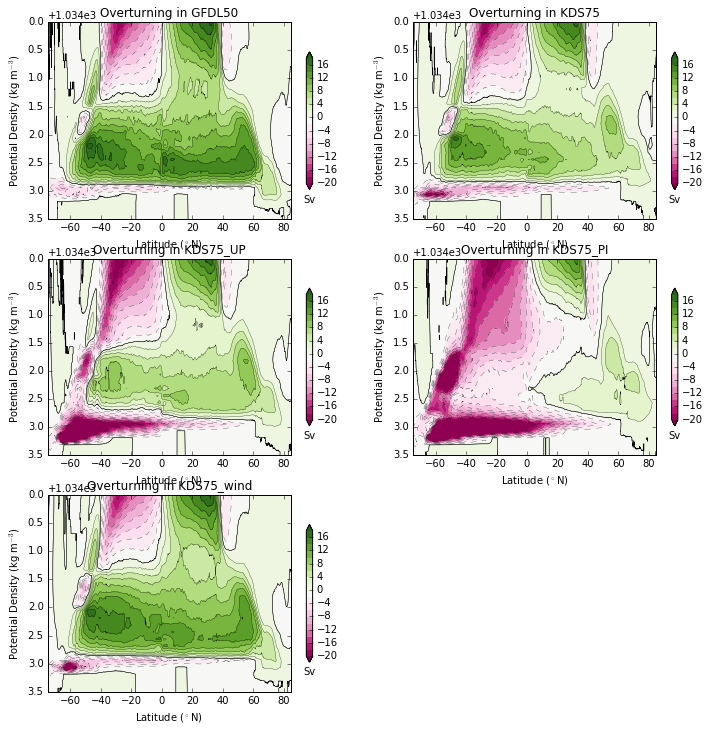

In [27]:
plt.figure(figsize=(12,12)) 
nplot = 0
for expt in expts: 
    nplot += 1
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/overturning.nc'))
    FileList.sort()

    plt.subplot(3,2,nplot)
    dsx = xr.open_mfdataset(FileList, concat_dim='time',decode_times=False, engine='netcdf4')
    plot_psi(dsx.ty_trans_rho[-20:,:,:].mean('time'), expt)

[########################################] | 100% Completed |  0.3s
1035.5625
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  1.4s
1035.5625
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  0.3s
1035.5625
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.5s
1035.5625
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.1s
1035.5625
[########################################] | 100% Completed |  0.1

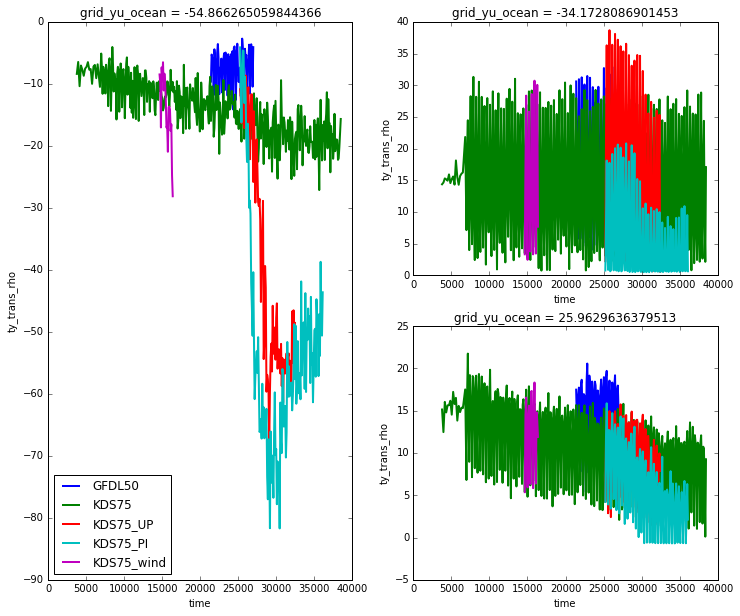

In [31]:
# for testing plotting, etc.
plt.figure(figsize=(12,10))
for expt in expts:
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/overturning.nc'))
    FileList.sort()

    dsx = xr.open_mfdataset(FileList, concat_dim='time',decode_times=False, engine='netcdf4')
    plt.subplot(121)
    dsx.ty_trans_rho[:,60:,585].min('potrho').plot(label=expt,linewidth=2) 
    ## still need to check sensitivity to the exaction location in the line above
    print(dsx.potrho[60].values)
    
    #Southern branch of the AMOC at 35S
    plt.subplot(222)
    dsx.ty_trans_rho[:,60:,880].max('potrho').plot(label=expt,linewidth=2) 
    
    # AMOC at 26N
    plt.subplot(224)
    dsx.ty_trans_rho[:,60:,1513].max('potrho').plot(label=expt,linewidth=2) 

#plt.title('AABW cell at 60S')
plt.subplot(121)
plt.legend(loc='lower left')

## PS. I really want to do an annual average here - need to get pd.to_datetime working

# Old overturning code
The following code calculates and plots overturning directly ... but is still too slow, so current method is to save overturning diagnostics as a netcdf file (see above).

<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)>
array([[  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   8.878143e-04,
          5.039134e-04,   4.951343e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   6.178831e-04,
          2.465724e-04,  -1.083469e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   5.200146e-04,
          1.157147e-04,  -1.218808e-04],
       ..., 
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -4.917386e-04,
         -2.587901e-04,   1.065158e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -4.917386e-04,
         -2.587901e-04,   1.065158e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -4.917386e-04,
         -2.587901e-04,   1.065158e-04]])
Coordinates:
    time           float64 3.846e+04
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * potrho         (potrho) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 ...

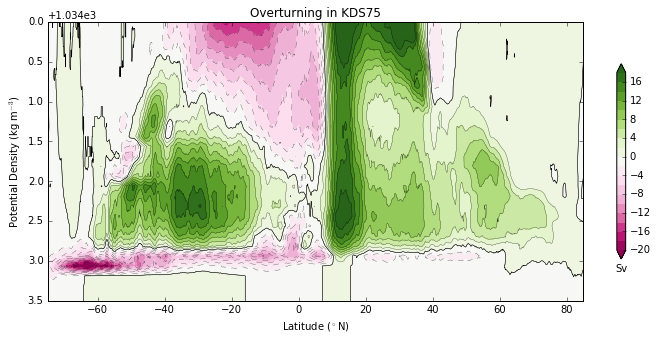

In [19]:
%%time 
psi_KDS = calculate_Ψ('KDS75', count=1)
psi_KDS.load()
plt.figure(figsize=(12,5))
plot_psi(psi_KDS, 'KDS75')
print(psi_KDS)
psi_KDS.to_netcdf('test.nc', mode='w', engine='netcdf4')

CPU times: user 1min 45s, sys: 26.1 s, total: 2min 11s
Wall time: 2min 12s


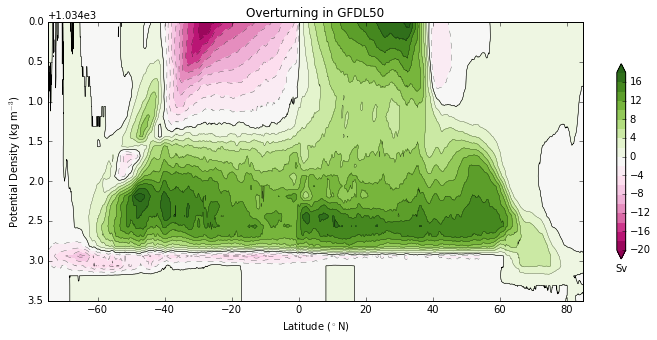

In [20]:
%%time 
psi_GFDL = calculate_Ψ('GFDL50', count=4)
psi_GFDL.load()
plt.figure(figsize=(12,5))
plot_psi(psi_GFDL, 'GFDL50')

CPU times: user 1min 47s, sys: 28.4 s, total: 2min 16s
Wall time: 2min 17s


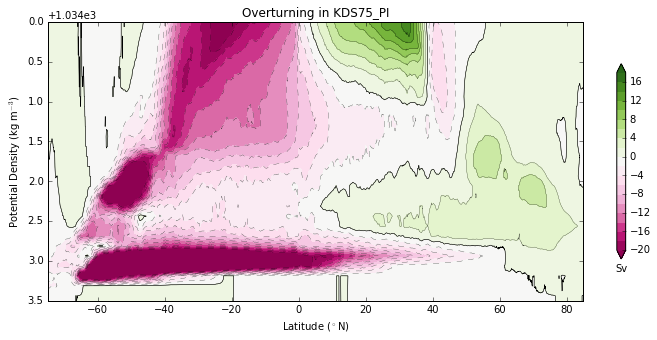

In [21]:
%%time 
psi_KDS_PI = calculate_Ψ('KDS75_PI', count=4)
psi_KDS_PI.load()
plt.figure(figsize=(12,5))
plot_psi(psi_KDS_PI, 'KDS75_PI')

CPU times: user 1min 47s, sys: 21.3 s, total: 2min 8s
Wall time: 2min 9s


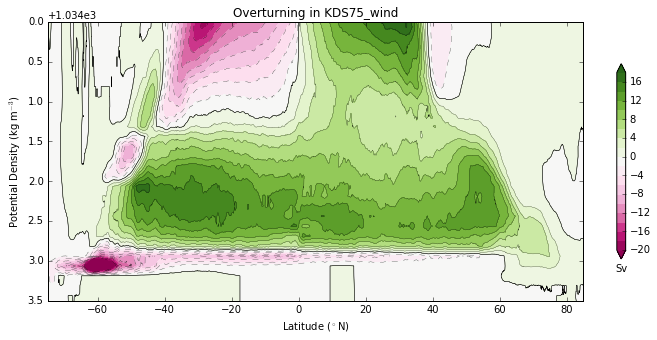

In [22]:
%%time 
psi_KDS_wind = calculate_Ψ('KDS75_wind', count=4)
psi_KDS_wind.load()
plt.figure(figsize=(12,5))
plot_psi(psi_KDS_wind, 'KDS75_wind')

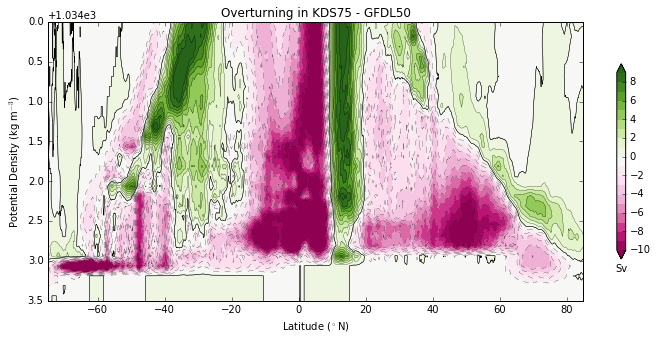

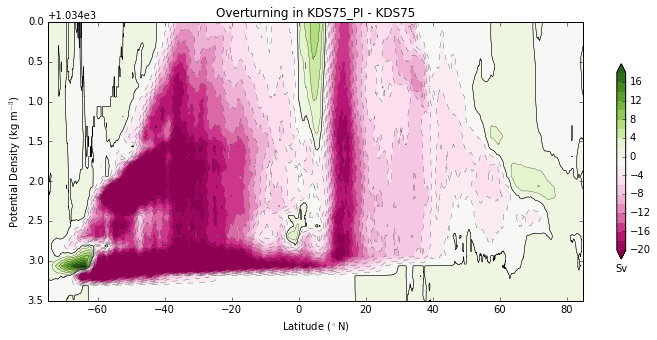

In [23]:
psi_diff = psi_KDS - psi_GFDL
plt.figure(figsize=(12,5))
plot_psi(psi_diff, 'KDS75 - GFDL50', clev = np.arange(-10,10,1.0))

psi_diff = psi_KDS_PI - psi_KDS
plt.figure(figsize=(12,5))
plot_psi(psi_diff, 'KDS75_PI - KDS75')

In [24]:
print ('For densities exceeding: ', psi_KDS.potrho[68].values)
print ('And at latitude:', psi_KDS.grid_yu_ocean[500].values)
print ('GFDL50 Min', np.min(psi_GFDL[68:,500]).values)
print ('KDS75 Min', np.min(psi_KDS[68:,500]).values)

For densities exceeding:  1036.5625
And at latitude: -59.4677023349844
GFDL50 Min -5.681802918310182
KDS75 Min -20.54388894634539


# Indo Throughflow and other Straits
* THis is pretty much done now, but I'm retaining these files to document how we calculate transport for each strait.

<xarray.DataArray 'ty_trans' ()>
array(-1.473966432557063)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 -8.568


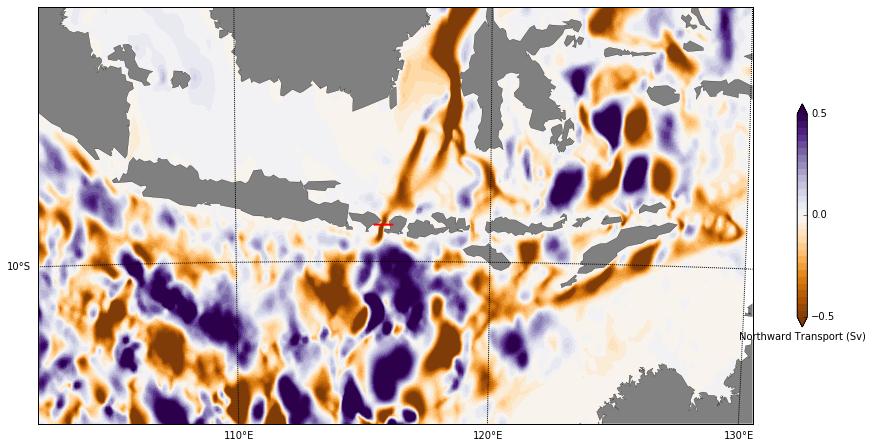

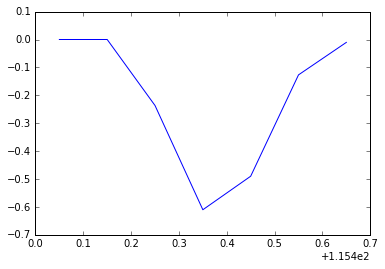

In [51]:
## test code to play with computation of lombok transport

# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,:1500,:500]
x = dsx.xt_ocean[:500]
y = dsx.yu_ocean[:1500]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Lombok, etc.
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-258,llcrnrlat=-16,urcrnrlon=-230,urcrnrlat=0,projection='stere',resolution='l',lon_0=-245,lat_0=-7)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
LombokDict = {'yloc':1158,'xmin':354,'xmax':361}
xx = np.array([X[LombokDict['yloc'],LombokDict['xmin']], X[LombokDict['yloc'],LombokDict['xmax']]])+360
yy = np.array([Y[LombokDict['yloc'],LombokDict['xmin']],Y[LombokDict['yloc'],LombokDict['xmax']]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')


plt.figure()
plt.plot(x[354:361]+360,transport[LombokDict['yloc'],LombokDict['xmin']:LombokDict['xmax']])
lombok_transport = np.sum(transport[LombokDict['yloc'],LombokDict['xmin']:LombokDict['xmax']])

print(lombok_transport)

<xarray.DataArray 'tx_trans' ()>
array(-1.2015297539478524)
Coordinates:
    time      float64 3.609e+04
    xu_ocean  float64 -235.0
<xarray.DataArray 'tx_trans' ()>
array(-4.769188458296412)
Coordinates:
    time      float64 3.609e+04
    xu_ocean  float64 -235.9


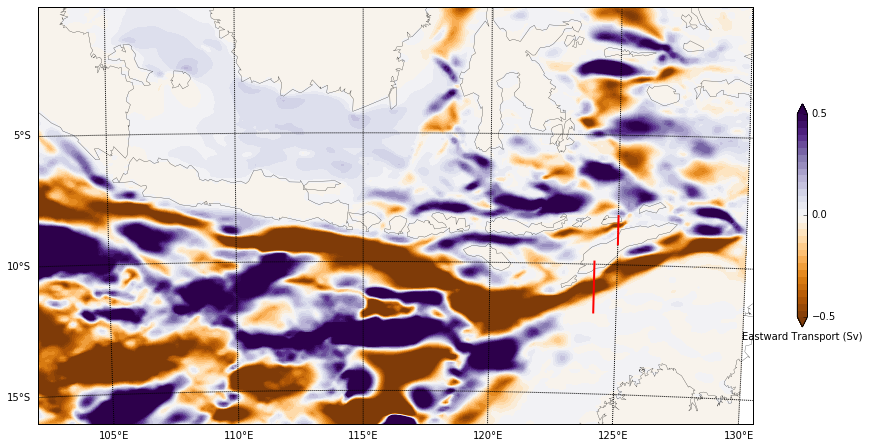

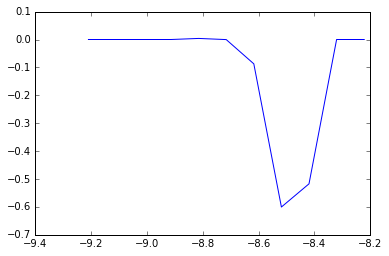

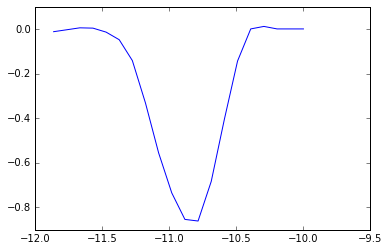

In [26]:
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output385/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
tx_trans = dsx.tx_trans[0,:,:1500,:500]
x = dsx.xu_ocean[:500]
y = dsx.yt_ocean[:1500]
transport = tx_trans.sum(axis=0)
xv, yv = np.meshgrid(x, y)

plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-258,llcrnrlat=-16,urcrnrlon=-230,urcrnrlat=0,projection='stere',resolution='l',lon_0=-245,lat_0=-7)
map.drawcoastlines(linewidth=0.25)
#map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,5.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,5.),labels=[True,False,False,True])
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Eastward Transport (Sv)')


# pick exact location and sum for each strait
# This for Ombai
OmbaiDict = {'xloc':449,'ymin':1152,'ymax':1163}
xx = np.array([X[OmbaiDict['ymin'],OmbaiDict['xloc']], X[OmbaiDict['ymax'],OmbaiDict['xloc']]])+360
yy = np.array([Y[OmbaiDict['ymin'],OmbaiDict['xloc']],Y[OmbaiDict['ymax'],OmbaiDict['xloc']]])
map.plot(xx,yy,linewidth=2,color='r')

# This for Timor
TimorDict = {'xloc':440,'ymin':1125,'ymax':1145}
xx = np.array([X[TimorDict['ymin'],TimorDict['xloc']], X[TimorDict['ymax'],TimorDict['xloc']]])+360
yy = np.array([Y[TimorDict['ymin'],TimorDict['xloc']],Y[TimorDict['ymax'],TimorDict['xloc']]])
map.plot(xx,yy,linewidth=2,color='r')

# plot and measure ombai
plt.figure()
plt.plot(y[OmbaiDict['ymin']:OmbaiDict['ymax']],transport[OmbaiDict['ymin']:OmbaiDict['ymax'],OmbaiDict['xloc']])
ombai_transport = np.sum(transport[OmbaiDict['ymin']:OmbaiDict['ymax'],OmbaiDict['xloc']])
print(ombai_transport)

# plot and measure timor
plt.figure()
plt.plot(y[TimorDict['ymin']:TimorDict['ymax']],transport[TimorDict['ymin']:TimorDict['ymax'],TimorDict['xloc']])
timor_transport = np.sum(transport[TimorDict['ymin']:TimorDict['ymax'],TimorDict['xloc']])
print(timor_transport)


<xarray.DataArray 'ty_trans' ()>
array(1.0250125366146676)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 65.75


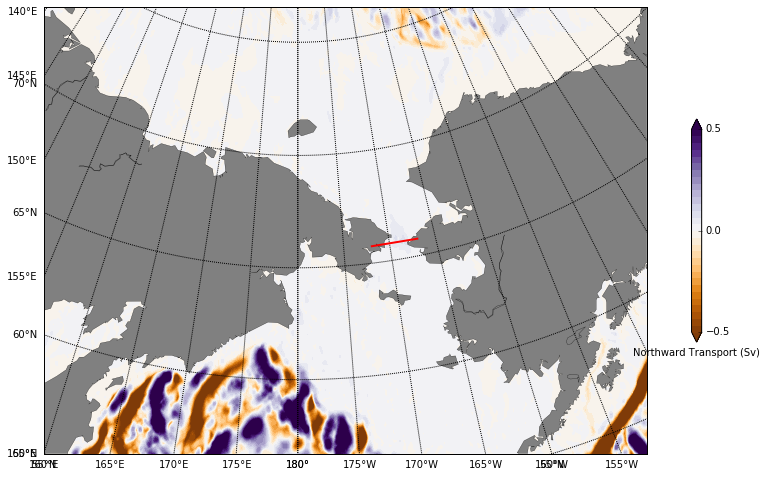

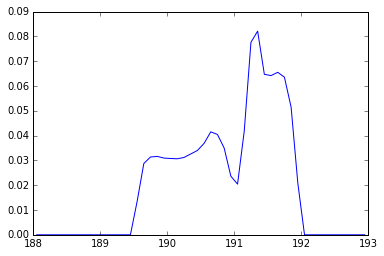

In [59]:
# Bering Strait
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,:,:1500]
x = dsx.xt_ocean[:1500]
y = dsx.yu_ocean[:]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Lombok, etc.
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-200,llcrnrlat=55,urcrnrlon=-130,urcrnrlat=70,projection='stere',resolution='l',lon_0=-180,lat_0=60)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,5.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,5.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
BeringDict = {'yloc':2125,'xmin':1080,'xmax':1130}
xx = np.array([X[BeringDict['yloc'],BeringDict['xmin']], X[BeringDict['yloc'],BeringDict['xmax']]])+360
yy = np.array([Y[BeringDict['yloc'],BeringDict['xmin']],Y[BeringDict['yloc'],BeringDict['xmax']]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')

plt.figure()
plt.plot(x[BeringDict['xmin']:BeringDict['xmax']]+360,transport[BeringDict['yloc'],BeringDict['xmin']:BeringDict['xmax']])
bering_transport = np.sum(transport[BeringDict['yloc'],BeringDict['xmin']:BeringDict['xmax']])

print(bering_transport)

<xarray.DataArray 'ty_trans' ()>
array(-4.258176312495108)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 65.75


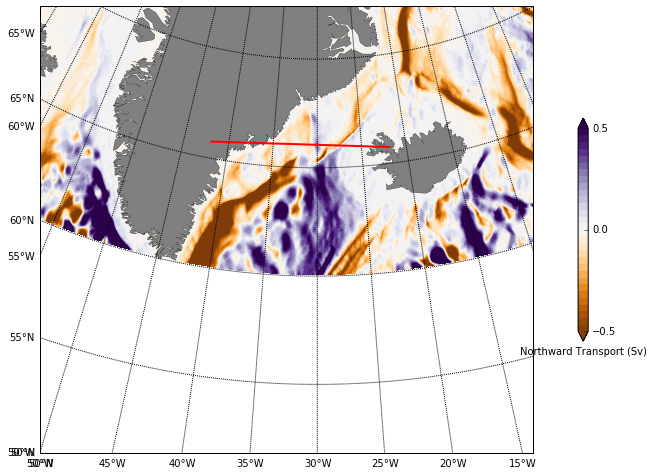

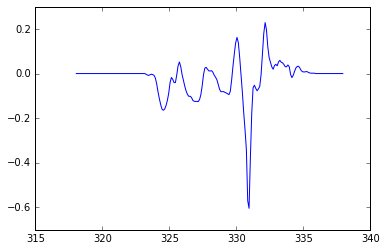

In [15]:
# Denmark Strait
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,2000:,2000:3000]
x = dsx.xt_ocean[2000:3000]
y = dsx.yu_ocean[2000:]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Iceland
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-50,llcrnrlat=50,urcrnrlon=0,urcrnrlat=70,projection='stere',resolution='l',lon_0=-30,lat_0=60)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,5.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,5.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
DenmarkDict = {'yloc':2125,'xmin':2380,'xmax':2580}
xx = np.array([X[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000], X[DenmarkDict['yloc']-2000,DenmarkDict['xmax']-2000]])+360
yy = np.array([Y[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000],Y[DenmarkDict['yloc']-2000,DenmarkDict['xmax']-2000]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')

plt.figure()
plt.plot(x[DenmarkDict['xmin']-2000:DenmarkDict['xmax']-2000]+360,transport[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000:DenmarkDict['xmax']-2000])
denmark_transport = np.sum(transport[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000:DenmarkDict['xmax']-2000])

print(denmark_transport)